Robotic Process Automation (RPA) Script

This python notebook will allow automating SAP data extraction and transformation without the need for any other 3rd party RPA software. For this you will need SAP and jupyter-notebook installed in yout PC. 

There are 3 mains step: 
* **STEP 1**: Create (generate) SAP automation script (.vbs) using SAP GUI scripting tool. Modify this script if necessary. 
* **STEP 2**: Create a python script to modify the .vbs script, run script and make any necessary changes to the extracted data. 
* **STEP 3**: Automate this notebook using windows task scheduler. 
       
 
***

Detailed explanation for each step:

**STEP 1:**
1. Please refer to part 1 (part 2 is for excel automation which is not relevant for us) of this link to create SAP Automation script: https://blogs.sap.com/2014/08/04/script-recording-playback-for-dummies/
    
2. A few general rule of thumb in creating the script above:
    1. Ensure each relevant parameter in text boxes are 'typed'. In some cases, there will be default values in some text boxes. Even if these values are correct, click on the text box and type the value again. This is to enforce the correct value. The default values may change at different run time therefore it is best practice to have the correct value captured in the vbs script.
    2. When saving a table results, please choose 'unconverted'. 
    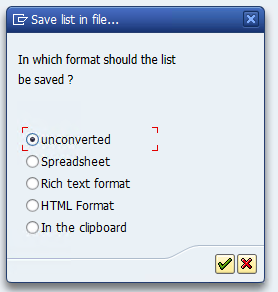
    
    The saved result txt file will appear like this:
    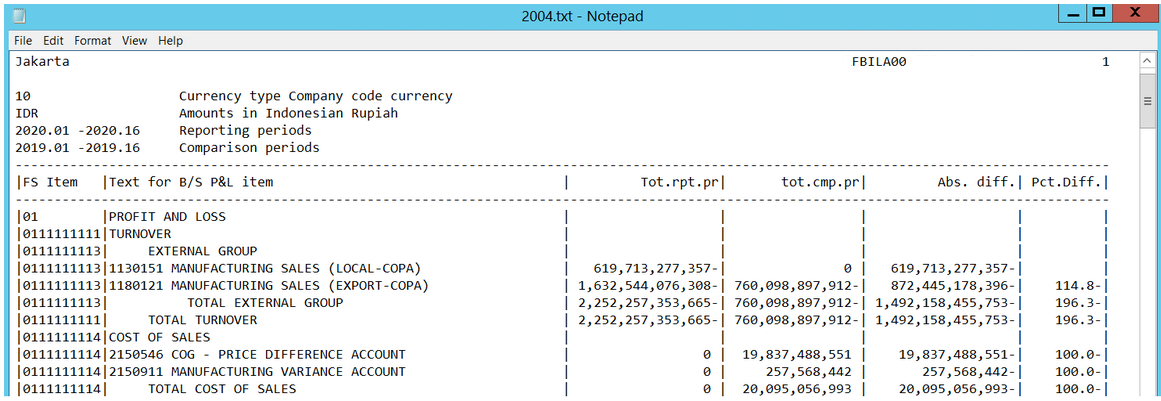


Copy the VBS script and paste it to variable vbs_template between triple apostrophe. Refer to cell no.3 below. The example here is given for table f.01.

**STEP 2:**
1. This python notebook will perform 3 tasks:
    1. Modify the earlier generated vbs script to change important parameters during runtime in each loop. 
    2. Run the modified .vbs script.
    3. Modify data extraction from table f.01 as an example.
2. Cell No.2 below creates function saplogon(). This function will open SAP GUI and enter the necessary access credentials. Please check:
    1. ln.12: SAP path
    2. ln.24: Connection type
    3. ln.38,39,40: Access credentials
3. Cell No.3 is the vbs script which was generated in step one above. In this script, only one company code is entered and the company code is replaced with '{0}'. This will allow us to pass one company code for each loop (using string.format()). This script will be updated and executed in 'for' loop. If all the company codes are included in the vbs script, then this loop will not be necessary. The script just needs to be executed once.
4. In Cell No.4, the vbs script is executed for each company code in each loop. 
5. Cell No.5 will open each result text file and remove unwanted row (rows without '|') and save a clean copy as a csv file. We will use the '|' separator to distinguish each column and save as a dataframe. If the SAP table results are saved in 'unconverted' format as suggested in STEP 1, then the separator is '|'. This entire data clean up and processing steps are dependent on your specific applicaiton. 
6. In this example, after the clean up process, the result is uploaded to a database in server. In your case this might be different. These lines (ln.68-72) are intentionally commented out to prevent accidental upload to this database.

**STEP 3:**
1. Once the notebook is completed you may execute this from windows task sceduler.
2. The parameters for jupyter notebook execution is provided below. It may be different depending on your setup:
    1. Program/script: C:\ProgramData\Anaconda3\Scripts\jupyter
    2. Add argument: nbconvert --to notebook --ExecutePreprocessor.timeout=600 --inplace --execute "F:\ETL_Python\RPA_SAP.ipynb"
   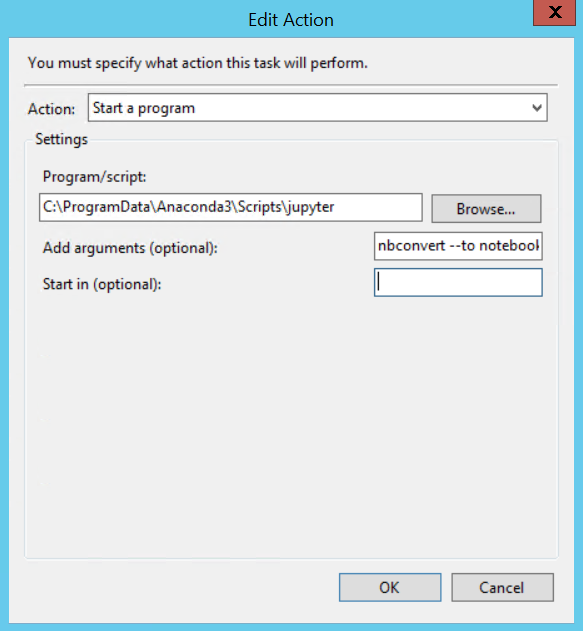

Additional Note
1. The vbs script strictly follows the gui during the time of script creation. If there happen to be any new/unexpected pop-up during run time, then the script will not execute successfully. For example, in my case, if there are too many other users accessing SAP at the same time with the same user credential, then there will be a an additional pop-up. This could be easily resolved by scheduling the python notebook to run on times where others are less likely to use the SAP, e.g 3.00am. 

In [1]:
# Cell No. 2

import win32com.client
import sys
import subprocess
import time
import pyautogui

# This function will Login to SAP from the SAP Logon window
def saplogin():
    try:
        path = r"C:\Program Files (x86)\SAP\FrontEnd\SAPgui\saplogon.exe"
        sap = subprocess.Popen(path)
        time.sleep(3)

        SapGuiAuto = win32com.client.GetObject('SAPGUI')
        if not type(SapGuiAuto) == win32com.client.CDispatch:
            return

        application = SapGuiAuto.GetScriptingEngine
        if not type(application) == win32com.client.CDispatch:
            SapGuiAuto = None
            return
        connection = application.OpenConnection("Connection - Name", True)

        if not type(connection) == win32com.client.CDispatch:
            application = None
            SapGuiAuto = None
            return

        session = connection.Children(0)
        if not type(session) == win32com.client.CDispatch:
            connection = None
            application = None
            SapGuiAuto = None
            return

        session.findById("wnd[0]/usr/txtRSYST-MANDT").text = "code"
        session.findById("wnd[0]/usr/txtRSYST-BNAME").text = "name"
        session.findById("wnd[0]/usr/pwdRSYST-BCODE").text = "pword"
        session.findById("wnd[0]").sendVKey(0)
        
    except:
        print(sys.exc_info()[0])



In [5]:
# Cell No. 3
# The .vbs script is saved here as a string variable

vbs_template = r'''
If Not IsObject(application) Then
   Set SapGuiAuto  = GetObject("SAPGUI")
   Set application = SapGuiAuto.GetScriptingEngine
End If
If Not IsObject(connection) Then
   Set connection = application.Children(0)
End If
If Not IsObject(session) Then
   Set session    = connection.Children(0)
End If
If IsObject(WScript) Then
   WScript.ConnectObject session,     "on"
   WScript.ConnectObject application, "on"
End If
session.findById("wnd[0]").maximize
session.findById("wnd[0]/tbar[0]/okcd").text = "f.01"
session.findById("wnd[0]").sendVKey 0
session.findById("wnd[0]/usr/tabsTABSTRIP_TABBL1/tabpUCOM1/ssub%_SUBSCREEN_TABBL1:RFBILA00:0001/radBILAGRID").select
session.findById("wnd[0]/usr/ctxtSD_BUKRS-LOW").text = "{0}"
session.findById("wnd[0]/usr/tabsTABSTRIP_TABBL1/tabpUCOM1/ssub%_SUBSCREEN_TABBL1:RFBILA00:0001/ctxtBILAVERS").text = "GFA2"
session.findById("wnd[0]/usr/tabsTABSTRIP_TABBL1/tabpUCOM1/ssub%_SUBSCREEN_TABBL1:RFBILA00:0001/txtBILBJAHR").text = "2020"
session.findById("wnd[0]/usr/tabsTABSTRIP_TABBL1/tabpUCOM1/ssub%_SUBSCREEN_TABBL1:RFBILA00:0001/txtB-MONATE-LOW").text = "1"
session.findById("wnd[0]/usr/tabsTABSTRIP_TABBL1/tabpUCOM1/ssub%_SUBSCREEN_TABBL1:RFBILA00:0001/txtB-MONATE-HIGH").text = "16"
session.findById("wnd[0]/usr/tabsTABSTRIP_TABBL1/tabpUCOM1/ssub%_SUBSCREEN_TABBL1:RFBILA00:0001/txtBILVJAHR").text = "2019"
session.findById("wnd[0]/usr/tabsTABSTRIP_TABBL1/tabpUCOM1/ssub%_SUBSCREEN_TABBL1:RFBILA00:0001/txtV-MONATE-LOW").text = "1"
session.findById("wnd[0]/usr/tabsTABSTRIP_TABBL1/tabpUCOM1/ssub%_SUBSCREEN_TABBL1:RFBILA00:0001/txtV-MONATE-HIGH").text = "16"
session.findById("wnd[0]/usr/tabsTABSTRIP_TABBL1/tabpUCOM1/ssub%_SUBSCREEN_TABBL1:RFBILA00:0001/ctxtBILAGVAR").text = "1SAP"
session.findById("wnd[0]/usr/tabsTABSTRIP_TABBL1/tabpUCOM1/ssub%_SUBSCREEN_TABBL1:RFBILA00:0001/ctxtBILAGVAR").setFocus
session.findById("wnd[0]/usr/tabsTABSTRIP_TABBL1/tabpUCOM1/ssub%_SUBSCREEN_TABBL1:RFBILA00:0001/ctxtBILAGVAR").caretPosition = 4
session.findById("wnd[0]/tbar[1]/btn[8]").press
session.findById("wnd[1]/tbar[0]/btn[0]").press
session.findById("wnd[0]/mbar/menu[0]/menu[3]/menu[2]").select
session.findById("wnd[1]/tbar[0]/btn[0]").press
session.findById("wnd[1]/usr/ctxtDY_PATH").text = "C:\Users\subbiah.thannirmalai\Desktop\SAP\"
session.findById("wnd[1]/usr/ctxtDY_FILENAME").text = "{0}.txt"
session.findById("wnd[1]/usr/ctxtDY_FILENAME").caretPosition = 12
session.findById("wnd[1]/tbar[0]/btn[11]").press
session.findById("wnd[0]/tbar[0]/btn[12]").press
session.findById("wnd[0]/tbar[0]/btn[12]").press
'''

In [3]:
# Cell No. 4

saplogin()

CompName = ['1000','1001','1002','1003','1004']

# Company Code changed and vbs script executed in each loop.
for x in CompName:
    vbs_file = open(r'C:\Users\subbiah.thannirmalai\AppData\Roaming\SAP\SAP GUI\Scripts\Script3.vbs', "w")
    vbs_file.write(vbs_template.format(x))
    vbs_file.close()
    subprocess.call(['cscript.exe', r'C:\Users\subbiah.thannirmalai\AppData\Roaming\SAP\SAP GUI\Scripts\Script3.vbs'])

#Cancel first SAP window
pyautogui.hotkey('alt', 'f4')

#Click Yes on pop up window
pyautogui.press('tab')
pyautogui.press('enter')

#Cancel main login SAP window
pyautogui.hotkey('alt', 'f4')

print('All Done')

All Done


In [ ]:
# Cell No. 5

import pandas as pd
import re
import sqlalchemy 
import urllib
import time

#Open SAP GUI and enter access credentials.
saplogin()

CompName = ['1000','1001','1002','1003','1004']

for x in CompName:
    vbs_file = open(r'C:\Users\subbiah.thannirmalai\AppData\Roaming\SAP\SAP GUI\Scripts\Script3.vbs', "w")
    vbs_file.write(vbs_template.format(x))
    vbs_file.close()
    subprocess.call(['cscript.exe', r'C:\Users\subbiah.thannirmalai\AppData\Roaming\SAP\SAP GUI\Scripts\Script3.vbs'])

    time.sleep(5)
    
    #create new csv file.
    file_temp = open(r'C:\Users\subbiah.thannirmalai\Desktop\SAP\{}.csv'.format(x), 'w')

    #Copy relevant rows from .txt (saved result from vbs script execution) file to .csv file.
    with open (r'C:\Users\subbiah.thannirmalai\Desktop\SAP\{}.txt'.format(x), 'rt') as myfile:
        for row in myfile:
            if re.match(r'^[|]', row):
                file_temp.write(row)           

    file_temp.close()

    #Open the saved .csv file as a dataframe.
    df_x = pd.read_csv(r'C:\Users\subbiah.thannirmalai\Desktop\SAP\{}.csv'.format(x),sep = '|',encoding='latin1')

    #remove empty spaces in header
    df_x.columns = df_x.columns.str.strip()
    
    #If the current file is empty, the loop will skip to the next loop. 
    #All process below this line will not be executed for the current company code.
    if df_x.shape[0] == 1:
        continue
    
    #There will be multiple header present in the dataframe. Removing them.
    df_x = df_x.loc[~df_x['FS Item'].str.contains('FS Item')]

    #remove unwanted columns
    df_x.drop(df_x.columns[1], axis=1, inplace=True) 
    df_x.drop(df_x.columns[0], axis=1, inplace=True) 
    df_x.drop(df_x.columns[-1], axis=1, inplace=True)

    #Add a new column for company code
    df_x['Company Code'] = '{}'.format(x)
    
    #rearrange columns
    df_x = df_x[['Company Code','Text for B/S P&L item', 'Tot.rpt.pr', 'tot.cmp.pr', 'Abs. diff.',
           'Pct.Diff.']]
    #rename
    df_x.columns = ['Company Code','Texts','Reporting period','Comparison period',
                  'Absolute difference','Relative difference']

    #remove additional spaces from numbers
    df_x['Reporting period'] = df_x['Reporting period'].str.strip()
    df_x['Comparison period'] = df_x['Comparison period'].str.strip()
    df_x['Absolute difference'] = df_x['Absolute difference'].str.strip()
    df_x['Relative difference'] = df_x['Relative difference'].str.strip()

    ##Setup database
    #quoted = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=xxx.xx.xx.xx;DATABASE=VIEW")
    #sql_conn = sqlalchemy.create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted))
    
    ##Upload to database
    #df_x.to_sql('Test_Subbiah',con=sql_conn,if_exists='append', index=False)
    
    print('Done ',x)
    
#Cancel first SAP window
pyautogui.hotkey('alt', 'f4')

#Click Yes on pop up window
pyautogui.press('tab')
pyautogui.press('enter')

#Cancel main login SAP window
pyautogui.hotkey('alt', 'f4')

print('All Done')